# Copyright Netherlands eScience Center and Centrum Wiskunde & Informatica <br>
** Function     : Emotion recognition and forecast with ConvLSTM** <br>
** Author       : Yang Liu** <br>
** Contributor  : Tianyi Zhang (Centrum Wiskunde & Informatica)<br>
** Last Update  : 2021.02.08 ** <br>
** Last Update  : 2021.02.12 ** <br>
** Library      : Pytorth, Numpy, os, DLACs, matplotlib **<br>
Description     : This notebook serves to test the prediction skill of deep neural networks in emotion recognition and forecast. The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Many to one prediction.** <br>

Return Values   : Time series and figures <br>

**This project is a joint venture between NLeSC and CWI** <br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
import numbers
import pickle

# for data loading
import os
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
from scipy.signal import resample
#import scipy
import torch
import torch.nn.functional

sys.path.append("../")

import nemo
import nemo.ConvLSTM
import nemo.function
import nemo.metric

# for visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
datapath = 'C:\\Users\\nosta\\NEmo\\Data_CASE'
output_path = 'C:\\Users\\nosta\\NEmo\\results'
model_path = 'C:\\Users\\nosta\\NEmo\\models'
# please specify the constants for input data
window_size = 2000 # down-sampling constant
seq = 20
v_a = 0 # valance = 0, arousal = 1
# leave-one-out training and testing
num_s = 2

In [3]:
def load_data_new(window_size, num_s, v_a, datapath):
    """
    For long cuts of data and the type is pickle.
    """
    f = open(os.path.join(datapath, 'data_{}s'.format(int(window_size/100))),'rb')
    data = pickle.load(f)
    f.close()
    
    samples = data["Samples"]
    labels = data["label_s"]
    subject_id = data["Subject_id"]
    
    x_train = samples[np.where(subject_id!=num_s)[0],:,0:4]
    x_test = samples[np.where(subject_id==num_s)[0],:,0:4]
    y_train = np.zeros([0,int(window_size/seq),1])
    y_test = np.zeros([0,int(window_size/seq),1])
    for i in range(len(labels)):
        sig = resample(labels[i][:,v_a],int(window_size/seq)).reshape([1,-1,1])/9
        if subject_id[i] == num_s:
            y_test = np.concatenate([y_test,sig],axis = 0)
        else:
            y_train = np.concatenate([y_train,sig],axis = 0)

    return x_train, x_test, y_train, y_test

In [4]:
if __name__=="__main__":
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    x_train, x_test, y_train, y_test = load_data_new(window_size, num_s, v_a, datapath)
    #x_train, x_test, y_train, y_test = load_data_old(window_size, num_s, datapath) 
    # first check of data shape
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

*********************** extract variables *************************
(232, 2000, 4)
(8, 2000, 4)
(232, 100, 1)
(8, 100, 1)


In [5]:
    #################################################################################
    #########                      pre-processing                           #########
    #################################################################################
    # choose the target dimension for reshaping of the signals
    batch_train_size, sample_x_size, channels = x_train.shape
    batch_test_size, sample_x_size, _ = x_test.shape
    _, sample_y_size, _ = y_train.shape
    x_dim = 5
    y_dim = 5
    series_x_len = sample_x_size // (y_dim * x_dim)
    series_y_len = sample_y_size // (y_dim * x_dim)
    # reshape the input and labels
    sample_train_xy = np.reshape(x_train,[batch_train_size, series_x_len, y_dim, x_dim, channels])
    sample_test_xy = np.reshape(x_test,[batch_test_size, series_x_len, y_dim, x_dim, channels])
    label_c_train_xy = np.reshape(y_train,[batch_train_size, series_y_len, y_dim, x_dim])
    label_c_test_xy = np.reshape(y_test,[batch_test_size, series_y_len, y_dim, x_dim])
    #################################################################################
    #########                       normalization                           #########
    #################################################################################
    print('================  extract individual variables  =================')
    sample_1 = sample_train_xy[:,:,:,:,0]
    sample_2 = sample_train_xy[:,:,:,:,1]
    sample_3 = sample_train_xy[:,:,:,:,2]
    sample_4 = sample_train_xy[:,:,:,:,3]
    
    sample_1_test = sample_test_xy[:,:,:,:,0]
    sample_2_test = sample_test_xy[:,:,:,:,1]
    sample_3_test = sample_test_xy[:,:,:,:,2]
    sample_4_test = sample_test_xy[:,:,:,:,3] 
    
    # using indicator for training
    # video_label_3D = np.repeat(video_label[:,np.newaxis,:],series_len,1)
    # video_label_4D = np.repeat(video_label_3D[:,:,np.newaxis,:],y_dim,2)
    # video_label_xy = np.repeat(video_label_4D[:,:,:,np.newaxis,:],x_dim,3)
    # video_label_xy.astype(float)
    
    # length diff for training
    len_diff = series_x_len / series_y_len
    # for the output at certain loop iteration
    diff_output_iter = np.arange(len_diff-1, series_x_len, len_diff)
    print(diff_output_iter)

================  extract individual variables  =================
[19. 39. 59. 79.]


In [6]:
    # first check of data shape
    print(label_c_train_xy.shape)
    print(sample_1.shape)

(232, 4, 5, 5)
(232, 80, 5, 5)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [6]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 4
    hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [4, 3, 3, 2, 1]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    learning_rate = 0.001
    num_epochs = 50
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print ('*******************  cross validation and testing data  *********************')
    # mini-batch
    mini_batch_size = 28
    # iterations
    # iterations
    iterations = batch_train_size // mini_batch_size
    if batch_train_size % mini_batch_size != 0:
        extra_loop = True
        iterations += 1
    else:
        extra_loop = False
    print(extra_loop)

*******************  create basic dimensions for tensor and network  *********************
1.1.0
Is CUDA available? True
*******************  cross validation and testing data  *********************
True


In [8]:
    %%time
    print ('*******************  run ConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    _, sequence_len, height, width = sample_1.shape
    #_, sequence_len, height, width = sample_1_norm.shape
    # initialize our model
    model = nemo.ConvLSTM.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)

*******************  run ConvLSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Wxf): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Wxc): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (Whc): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Wxo): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
    (Who): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1))
    (Whi): Conv2d(2, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (Wxf): Conv2d(3, 2, kernel_size=(1, 1), stride=(1

In [ ]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

In [ ]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

In [9]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs * iterations)
    # loop of epoch
    for t in range(num_epochs):
        for i in range(iterations):
            # Clear stored gradient
            model.zero_grad()
            # loop
            loop_num = mini_batch_size
            if i == iterations - 1:
                if extra_loop:
                    loop_num = batch_train_size % mini_batch_size
            for j in range(loop_num):
            # loop of timestep
                # critical step for verifying the loss
                crit_step = 0            
                for timestep in range(sequence_len):
                    # hidden state re-initialized inside the model when timestep=0
                    #################################################################################
                    ########          create input tensor with multi-input dimension         ########
                    #################################################################################
                    # create variables
                    x_input = np.stack((sample_1[i*mini_batch_size+j,timestep,:,:],
                                        sample_2[i*mini_batch_size+j,timestep,:,:],
                                        sample_3[i*mini_batch_size+j,timestep,:,:],
                                        sample_4[i*mini_batch_size+j,timestep,:,:])) #vstack,hstack,dstack
                    x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
                    # Forward pass
                    y_pred, _ = model(x_var, timestep)
                    # counter for computing the loss
                    if timestep in diff_output_iter: # determined by the length of label
                        #################################################################################
                        ########       create training tensor with multi-input dimension         ########
                        #################################################################################
                        y_train_stack = np.stack((label_c_train_xy[i*mini_batch_size+j,crit_step,:,:])) #vstack,hstack,dstack
                        y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
                        crit_step = crit_step + 1 # move forward
                        #################################################################################   
                        # choose training data
                        y_train = y_var        
                        # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
                        # Please Make Sure y_pred & y_train have the same dimension
                        # accumulate loss
                        if timestep == diff_output_iter[0]:
                            loss = loss_fn(y_pred, y_train)
                        else:
                            loss += loss_fn(y_pred, y_train)
            # print loss at certain iteration
            if i % 50 == 0:
                print("Epoch {} Iteration {} MSE: {:0.3f}".format(t, i, loss.item()))
                # Gradcheck requires double precision numbers to run
                #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
                #print(res)
            hist[i+t*iterations] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()
    
            # Backward pass
            loss.backward(retain_graph=True)

            # Update parameters
            optimiser.step()
            
        # save the model
        if t % 20 == 0:
            # (recommended) save the model parameters only
            torch.save(model.state_dict(), os.path.join(model_path,'convlstm_emotion_epoch_{}.pkl'.format(t)))
            # save the entire model
            #torch.save(model, os.path.join(output_path,'convlstm.pkl'))
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(model_path,'convlstm_emotion.pkl'))
    # save the entire model
    #torch.save(model, os.path.join(output_path,'convlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 Iteration 0 MSE: 2.212
Epoch 0 Iteration 5 MSE: 1.258
Epoch 1 Iteration 0 MSE: 2.154
Epoch 1 Iteration 5 MSE: 1.217
Epoch 2 Iteration 0 MSE: 2.100
Epoch 2 Iteration 5 MSE: 1.177
Epoch 3 Iteration 0 MSE: 2.047
Epoch 3 Iteration 5 MSE: 1.139
Epoch 4 Iteration 0 MSE: 1.996
Epoch 4 Iteration 5 MSE: 1.103
Epoch 5 Iteration 0 MSE: 1.947
Epoch 5 Iteration 5 MSE: 1.067
Epoch 6 Iteration 0 MSE: 1.899
Epoch 6 Iteration 5 MSE: 1.033
Epoch 7 Iteration 0 MSE: 1.852
Epoch 7 Iteration 5 MSE: 0.999
Epoch 8 Iteration 0 MSE: 1.807
Epoch 8 Iteration 5 MSE: 0.966
Epoch 9 Iteration 0 MSE: 1.761
Epoch 9 Iteration 5 MSE: 0.933
Epoch 10 Iteration 0 MSE: 1.716
Epoch 10 Iteration 5 MSE: 0.901
Epoch 11 Iteration 0 MSE: 1.671
Epoch 11 Iteration 5 MSE: 0.869
Epoch 12 Iteration 0 MSE: 1.625
Epoch 12 Iteration 5 MSE: 0.836

*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


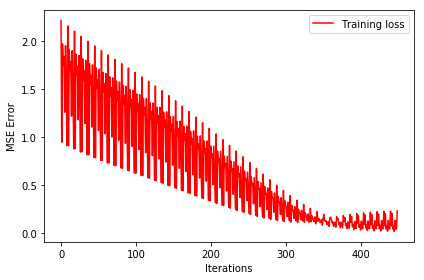

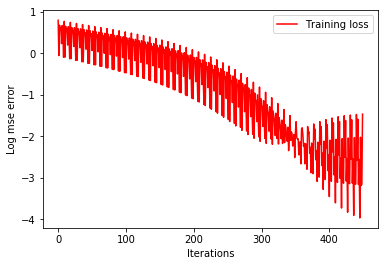

<Figure size 432x288 with 0 Axes>

In [10]:
    #################################################################################
    ###########                 after training statistics                 ###########
    #################################################################################
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.xlabel('Iterations')
    plt.ylabel('MSE Error')
    plt.legend()
    plt.tight_layout()
    fig00.savefig(os.path.join(output_path,'ConvLSTM_train_mse_error.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.xlabel('Iterations')
    plt.ylabel('Log mse error')
    plt.legend()
    plt.show()
    plt.tight_layout()
    fig01.savefig(os.path.join(output_path,'ConvLSTM_train_log_mse_error.png'),dpi=150)

In [11]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    
    # error score for temporal-spatial fields, without keeping spatial pattern
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        It calculates RMSE over the domain, not over time. The spatial structure
        will not be kept.
        Parameter
        ----------------------
        x: input time series with the shape [time, lat, lon]
        """
        x_series = x.reshape(x.shape[0],-1)
        y_series = y.reshape(y.shape[0],-1)
        rmse = np.sqrt(np.mean((x_series - y_series)**2,1))
        rmse_std = np.std(np.sqrt((x_series - y_series)**2,1))
    
        return rmse, rmse_std
    
    # error score for temporal-spatial fields, keeping spatial pattern
    def MAE(x,y):
        """
        Calculate the MAE. x is input series and y is reference series.
        It calculate MAE over time and keeps the spatial structure.
        """
        mae = np.mean(np.abs(x-y),0)
        
        return mae
    
    def MSE(x, y):
        """
        Calculate the MSE. x is input series and y is reference series.
        """
        mse = np.mean((x-y)**2)
        
        return mse

*******************  evaluation matrix  *********************


##############################################################
###################  start prediction loop ###################
##############################################################
*******************  Loss with time  **********************
Wall time: 3.72 s


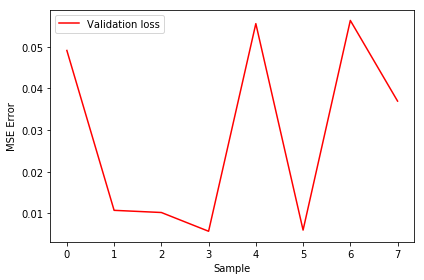

In [12]:
    %%time
    #################################################################################
    ########                           prediction                            ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # forecast array
    pred_label = np.zeros((batch_test_size, series_y_len, y_dim, x_dim),dtype=float)
    # calculate loss for each sample
    hist_label = np.zeros(batch_test_size)
    for n in range(batch_test_size):
        # Clear stored gradient
        model.zero_grad()
        # critical step for saving the output
        crit_step_pred = 0
        for timestep in range(sequence_len):
            x_input = np.stack((sample_1_test[n,timestep,:,:],
                                sample_2_test[n,timestep,:,:],
                                sample_3_test[n,timestep,:,:],
                                sample_4_test[n,timestep,:,:]))
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).to(device)
            # make prediction
            last_pred, _ = model(x_var_pred, timestep)
            # counter for prediction
            if timestep in diff_output_iter: # determined by the length of label
                # GPU data should be transferred to CPU
                pred_label[n,crit_step_pred,:,:] = last_pred[0,0,:,:].cpu().data.numpy()
                crit_step_pred = crit_step_pred + 1 # move forward
        # compute the error for each sample
        hist_label[n] = MSE(label_c_test_xy[n,:,:,:], pred_label[n,:,:,:])
    
    # save prediction as npz file
    np.savez_compressed(os.path.join(output_path,'ConvLSTM_emotion_pred.npz'),
                        label_c = pred_label)
    # plot the error
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist_label, 'r', label="Validation loss")
    plt.xlabel('Sample')
    plt.ylabel('MSE Error')
    plt.legend()
    plt.tight_layout()
    fig00.savefig(os.path.join(output_path,'ConvLSTM_pred_mse_error.png'),dpi=150) 

In [13]:
    #####################################################################################
    ########         visualization of prediction and implement metrics           ########
    #####################################################################################
    # compute mse
    mse_label = MSE(label_c_test_xy, pred_label)
    print(mse_label)
    # save output as csv file
    with open(os.path.join(output_path, "MSE_ConvLSTM_emotion.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["emotion prediction"])  # write header
        writer.writerow(["label"])
        writer.writerow([mse_label])

0.02882709742851517
